# Classifying Malicious Software using Random Forest

The emergence of graph data across many scientific fields has led to intense interest in the development of representation learning techniques that encode structured information into low dimensional space for a variety of important downstream tasks (e.g., toxic molecule detection, community clustering, malware detection).

In this lab, we walk through how to use **random forests** to classify different *types* of malicious software using function call graphs (FCGs) extracted from malicious files. Each FCG represents the calling relationships between functions in a program, where nodes are functions and edges indicate inter-procedural calls. We obtain these FCGs from [**MalNet**](https://mal-net.org/), a large-scale graph classification database.Specifically, we will look at how to:

- Part 1: Download and process the data,
- Part 2: Get train and test data
- Part 3: Random Forest Classifier Hyperparameter tuning
- Part 4: Measuring Accuracy


## Part 1. Downloading and processing the data

We first download the graph data from the MalNet website, [here](http://malnet.cc.gatech.edu/graph-data/malnet-graphs-tiny.tar.gz) and [here](http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip), and store it locally in the folder `notebooks/`.

In [ ]:
import shutil
import requests

def download_data(url, target_path):
    """
    Download MalNet-Tiny data to the local device
    :param: url: a string representing the url download location
    :param: target_path: a string representing the local storage location
    """

    response = requests.get(url, stream=True)

    # check that the data was successfully retrieved
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())

    # uncompress the downloads
    shutil.unpack_archive(target_path, 'notebooks/')

download_data(url='http://malnet.cc.gatech.edu/graph-data/malnet-graphs-tiny.tar.gz', target_path='notebooks/malnet-graphs-tiny.tar.gz')
download_data(url='http://malnet.cc.gatech.edu/split-info/split_info_tiny.zip', target_path='notebooks/split_info_tiny.zip')

Now that the data has been downloaded, lets gather the file paths and label information for the train, validation and test sets.

In [ ]:
def get_split_info(data_type, data_dir='notebooks/malnet-graphs-tiny/'):
    """
    Get the file paths and labels for the train, val or test data
    :param: data_type: a string representing the data selection 'train', 'val' or 'test'
    :param: the graph directory
    :return: list of graph filepaths, list of labels, and label dictionary 
    """

    # read the train/val/test file split info into memory
    with open('notebooks/split_info_tiny/type/{}.txt'.format(data_type), 'r') as f:
        lines = f.readlines()

    # parse graph file paths
    files = [data_dir + l.strip() + '.edgelist' for l in lines]
    print('Number of {} samples: {}'.format(data_type, len(files)))

    # get the class labels for each graph
    graph_classes = sorted(list(set([file.split(data_dir)[1].split('/')[0] for file in files])))
    label_dict = {t: idx for idx, t in enumerate(graph_classes)}
    labels = [label_dict[file.split(data_dir)[1].split('/')[0]] for file in files]

    return files, labels, label_dict


files_train, train_labels, label_dict = get_split_info(data_type='train')
files_val, val_labels, _ = get_split_info(data_type='val')
files_test, test_labels, _ = get_split_info(data_type='test')

Number of train samples: 3500
Number of val samples: 500
Number of test samples: 1000


To get a feeling for the data we are going to be working with, lets visualize one of the graphs.

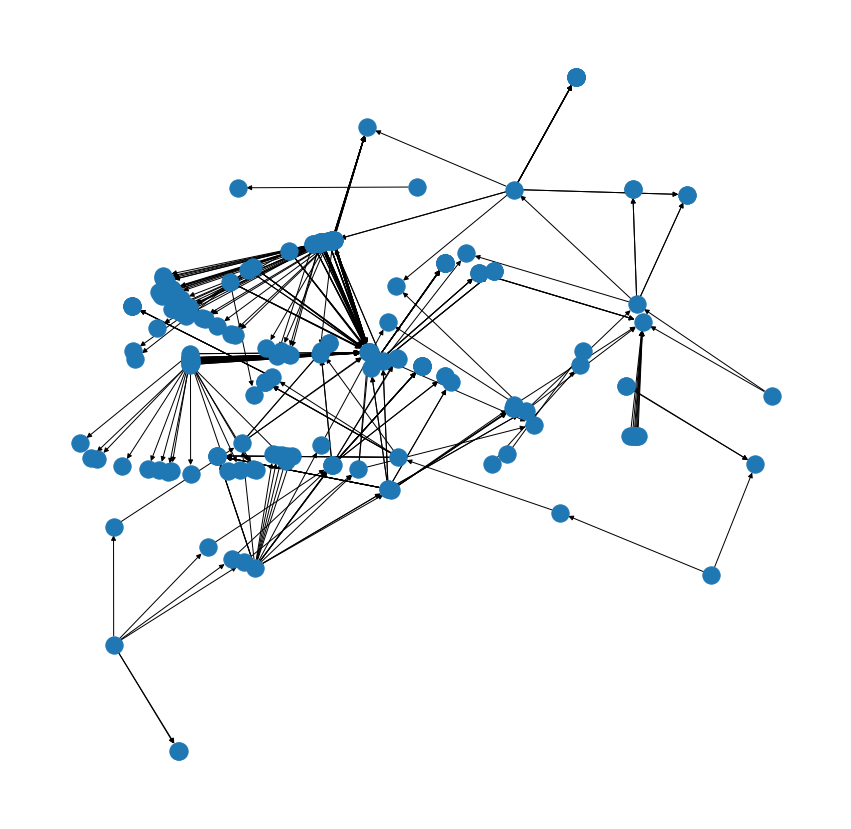

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# load a single function call graph
graph = nx.read_edgelist(files_train[2], create_using=nx.DiGraph)

# plot the graph using the Kamada Kawai graph layout
plt.figure(num=None, figsize=(15, 15))
plt.axis('off')
nx.draw_kamada_kawai(graph)


In the figure above, we can see that the graph is directed which represents the interprocedural function calls i.e., each node is a function and an edge represents that function calling another function.

## Part 2. Get train and test data

Let's now break our data into a training set, a validation set, and a testing set. We will train our random forest models with our training data and then tune the model's hyperparameters using the validation data. We will finally evaluate the best random forest model using our testing data.

In [ ]:
import numpy as np
import networkx as nx
train_arr, val_arr, test_arr = [], [], []

In [ ]:
for file in files_train:
  graph = nx.read_edgelist(file)
  train_arr.append([len(graph.nodes), len(graph.edges)])

In [ ]:
for file in files_val:
  graph = nx.read_edgelist(file)
  val_arr.append([len(graph.nodes), len(graph.edges)])

In [ ]:
for file in files_test:
  graph = nx.read_edgelist(file)
  test_arr.append([len(graph.nodes), len(graph.edges)])

Now that we have our sets of data, we will need to convert it into values that cuML's random forest classifier (RFC) takes. The documentation for cuML's RFC can be found [here](https://docs.rapids.ai/api/cuml/stable/api.html#cuml.ensemble.RandomForestClassifier).

In [ ]:
train_arr = np.array(train_arr).astype(np.float32)
val_arr = np.array(val_arr).astype(np.float32)
test_arr = np.array(test_arr).astype(np.float32)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [ ]:
#Looking at the shape of all the arrays
print("train_arr: ", train_arr.shape)
print("val_arr: ", val_arr.shape)
print("test_arr: ", test_arr.shape)

train_arr:  (3500, 2)
val_arr:  (500, 2)
test_arr:  (1000, 2)


In [ ]:
print("train_arr dict: ", label_dict)

train_arr dict:  {'addisplay': 0, 'adware': 1, 'benign': 2, 'downloader': 3, 'trojan': 4}


## Part 3. Random Forest Classifier Hyperparamter tuning

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRFC

Here are all the different hyperparameter arguments we want to vary and the respective inputs that we want to test.

In [ ]:
n_estimators_choice = [25, 50, 100, 200]
bootstrap_choice = [True, False]
max_depth_choice = [4, 16, 32]
random_seed = 42

Test all the different combinations of hyperparameters and return the set of hyperparameters that fit the validation dataset the best. If there are multiple combinations that achieve the same accuracy, use the combination that leads to the simplest model.

In [ ]:
best_est = -1
best_boot = False
best_depth = -1
best_score = -1

# Test all the different combinations of hyperparameters and return the set of hyperparameters that 
# fit the validation dataset the best. 
# If there are multiple combinations that achieve the same accuracy, use the combination that 
# leads to the simplest model.

# ... implemente your code here

Display the set of ideal hyperparameter values.

In [ ]:
print(best_score)
print(best_est)
print(best_boot)
print(best_depth)

## Part 4. Measuring accuracy

Calculate the accuracy score of testing dataset using the ideal model with its respective hyperparameters.

In [ ]:
# Print the accuracy score of testing dataset using the ideal model with its respective hyperparameters.

# ... implemente your code here
test_score = cuml_model.score(test_arr, test_labels)
print(test_score)